In [136]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import os
import seaborn as sns
import networkx as nx
from scipy import stats

# Eurovision Song Contest (ESC) Analysis

## Data Familiarization

In [137]:
# Get current directory
cwd = os.getcwd()
print(cwd)

c:\Users\mate1\OneDrive\Escritorio\Repository\Eurovision_Contest_Analysis


In [138]:
# Load data
df_votes = pd.read_csv('Data/votes.csv')
df_votes.head()

,year,round,from_country_id,to_country_id,from_country,to_country,total_points,tele_points,jury_points
0,1957,final,at,nl,at,nl,6,NaN,NaN
1,1957,final,at,fr,at,fr,0,NaN,NaN
2,1957,final,at,dk,at,dk,0,NaN,NaN
3,1957,final,at,lu,at,lu,3,NaN,NaN
4,1957,final,at,de,at,de,0,NaN,NaN


In [139]:
# Get the initial and last years of the data
initial_year = df_votes['year'].min()
final_year = df_votes['year'].max()
print('Initial year:', initial_year)
print('Final year:', final_year)

Initial year: 1957
Final year: 2023


### Data Cleaning

In this work we are only interested in the final round.

In [140]:
# Get only the final round
df_final_round = df_votes[df_votes['round'] == 'final']

In [141]:
# # Remove giving 0 points
# df_final_round = df_final_round[df_final_round['total_points'] > 0]
# df_final_round

In [142]:
# Get the total number of countries
total_countries = df_final_round['from_country_id']
total_countries = np.array(total_countries)
total_countries = np.unique(total_countries)
print('Total countries:', total_countries)
print('Number of countries:', len(total_countries))

Total countries: ['ad' 'al' 'am' 'at' 'au' 'az' 'ba' 'be' 'bg' 'by' 'ch' 'cs' 'cy' 'cz'
 'de' 'dk' 'ee' 'es' 'fi' 'fr' 'gb' 'ge' 'gr' 'hr' 'hu' 'ie' 'il' 'is'
 'it' 'lt' 'lu' 'lv' 'ma' 'mc' 'md' 'me' 'mk' 'mt' 'nl' 'no' 'pl' 'pt'
 'ro' 'rs' 'ru' 'se' 'si' 'sk' 'sm' 'tr' 'ua' 'wld' 'yu']
Number of countries: 53


In [143]:
# # Broadcast the Yugoslavia points to their actual countries
# broadcast = {
#     'yu': ['ba', 'hr', 'mk', 'rs', 'si'],
#     'cs': ['rs', 'me']
# }

# df_final_round['from_country_id'] = df_final_round['from_country_id'].apply(lambda x: broadcast[x] if x in broadcast.keys() else x)
# df_final_round['to_country_id'] = df_final_round['to_country_id'].apply(lambda x: broadcast[x] if x in broadcast.keys() else x)
# df_final_round.explode('from_country_id').explode('to_country_id')

In [144]:
# Dictionary with the real name of the countries
country_id_to_name = {
    'ad': 'Andorra',
    'al': 'Albania',
    'am': 'Armenia',
    'at': 'Austria',
    'au': 'Australia',
    'az': 'Azerbaijan',
    'ba': 'Bosnia and Herzegovina',
    'be': 'Belgium',
    'bg': 'Bulgaria',
    'by': 'Belarus',
    'ch': 'Switzerland',
    'cs': 'Serbia and Montenegro',  # Historical ID
    'cy': 'Cyprus',
    'cz': 'Czech Republic',
    'de': 'Germany',
    'dk': 'Denmark',
    'ee': 'Estonia',
    'es': 'Spain',
    'fi': 'Finland',
    'fr': 'France',
    'gb': 'United Kingdom',
    'ge': 'Georgia',
    'gr': 'Greece',
    'hr': 'Croatia',
    'hu': 'Hungary',
    'ie': 'Ireland',
    'il': 'Israel',
    'is': 'Iceland',
    'it': 'Italy',
    'lt': 'Lithuania',
    'lu': 'Luxembourg',
    'lv': 'Latvia',
    'ma': 'Morocco',
    'mc': 'Monaco',
    'md': 'Moldova',
    'me': 'Montenegro',
    'mk': 'North Macedonia',
    'mt': 'Malta',
    'nl': 'Netherlands',
    'no': 'Norway',
    'pl': 'Poland',
    'pt': 'Portugal',
    'ro': 'Romania',
    'rs': 'Serbia',
    'ru': 'Russia',
    'se': 'Sweden',
    'si': 'Slovenia',
    'sk': 'Slovakia',
    'sm': 'San Marino',
    'tr': 'Turkey',
    'ua': 'Ukraine',
    'wld': 'World',  # Possible placeholder for aggregated data
    'yu': 'Yugoslavia'  # Historical ID
}

In [145]:
df_final_round['from_country'] = df_final_round['from_country'].map(country_id_to_name)
df_final_round['to_country'] = df_final_round['to_country'].map(country_id_to_name)
df_final_round

C:\Users\mate1\AppData\Local\Temp\ipykernel_15656\1287897805.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_final_round['from_country'] = df_final_round['from_country'].map(country_id_to_name)
C:\Users\mate1\AppData\Local\Temp\ipykernel_15656\1287897805.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_final_round['to_country'] = df_final_round['to_country'].map(country_id_to_name)


,year,round,from_country_id,to_country_id,from_country,to_country,total_points,tele_points,jury_points
0,1957,final,at,nl,Austria,Netherlands,6,NaN,NaN
1,1957,final,at,fr,Austria,France,0,NaN,NaN
2,1957,final,at,dk,Austria,Denmark,0,NaN,NaN
3,1957,final,at,lu,Austria,Luxembourg,3,NaN,NaN
4,1957,final,at,de,Austria,Germany,0,NaN,NaN
...,...,...,...,...,...,...,...,...,...
51349,2023,final,wld,al,World,Albania,6,6.0,NaN
51350,2023,final,wld,pt,World,Portugal,0,0.0,NaN
51351,2023,final,wld,rs,World,Serbia,0,0.0,NaN
51352,2023,final,wld,gb,World,United Kingdom,0,0.0,NaN


### Number of Participations

In [146]:
def participation_counts_f(df, initial_year, final_year):
    
    # Get the number of participations of each country
    df = df[(df['year'] >= initial_year) & (df['year'] <= final_year)]

    # Combine all country IDs into a single column with the corresponding year
    participations = pd.concat([
        df[['year', 'from_country']].rename(columns={'from_country': 'country'}),
        df[['year', 'to_country']].rename(columns={'to_country': 'country'}),
    ])

    # Explode the lists into individual rows
    participations = participations.explode('country')

    # Drop duplicates to ensure each country-year combination is only counted once
    participations = participations.drop_duplicates()

    # Count the number of unique years each country participated
    participation_counts = participations.groupby('country')['year'].nunique()

    # Convert the result to a DataFrame
    participation_counts = participation_counts.reset_index()
    participation_counts.columns = ['country', 'participation_count']
    
    return participation_counts

In [147]:
# Get the number of participations of each country

participation_counts = participation_counts_f(df_final_round, initial_year, final_year)

# Represent in a table the number of participations of each country with their complete name
participation_counts = participation_counts.sort_values('participation_count', ascending=False)
participation_counts[['country', 'participation_count']]


,country,participation_count
50,United Kingdom,65
18,Germany,65
16,France,64
7,Belgium,63
33,Netherlands,62
47,Switzerland,62
46,Sweden,62
45,Spain,62
35,Norway,61
22,Ireland,56


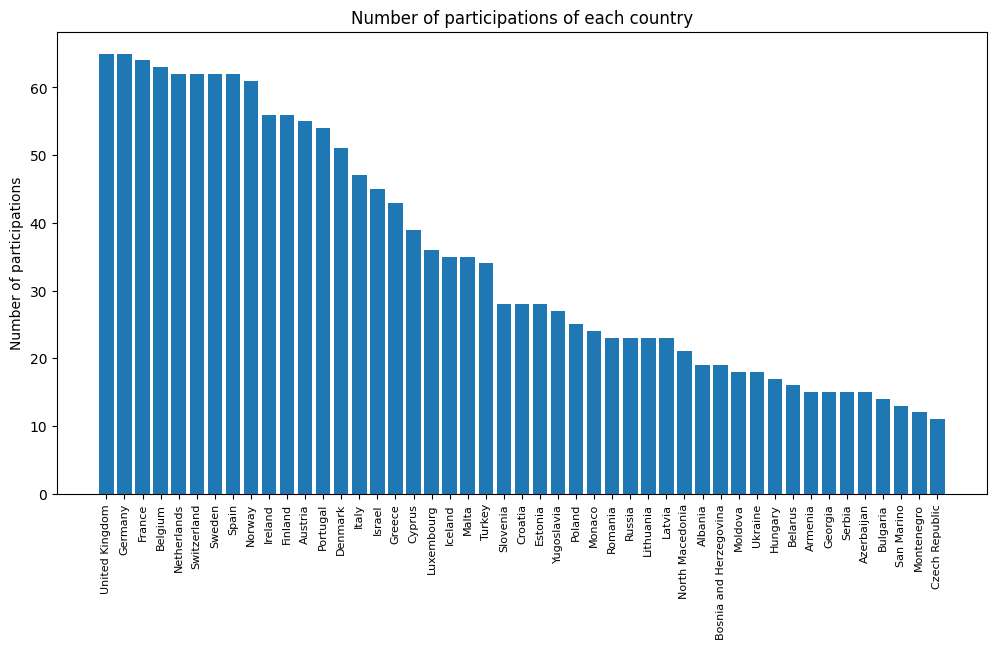

In [148]:
# Plot the number of participations of each country with a minimum of 10 participations
x = participation_counts[participation_counts['participation_count'] >= 10]

plt.figure(figsize=(12, 6))
plt.bar(x['country'], x['participation_count'])
plt.xticks(rotation=90, fontsize=8)    
plt.ylabel('Number of participations')
plt.title('Number of participations of each country')
plt.show()

In [149]:
countries = np.array(participation_counts['country'])
print('Countries:', countries)
print('Number of countries:', len(countries))

Countries: ['United Kingdom' 'Germany' 'France' 'Belgium' 'Netherlands' 'Switzerland'
 'Sweden' 'Spain' 'Norway' 'Ireland' 'Finland' 'Austria' 'Portugal'
 'Denmark' 'Italy' 'Israel' 'Greece' 'Cyprus' 'Luxembourg' 'Iceland'
 'Malta' 'Turkey' 'Slovenia' 'Croatia' 'Estonia' 'Yugoslavia' 'Poland'
 'Monaco' 'Romania' 'Russia' 'Lithuania' 'Latvia' 'North Macedonia'
 'Albania' 'Bosnia and Herzegovina' 'Moldova' 'Ukraine' 'Hungary'
 'Belarus' 'Armenia' 'Georgia' 'Serbia' 'Azerbaijan' 'Bulgaria'
 'San Marino' 'Montenegro' 'Czech Republic' 'Australia' 'Slovakia'
 'Andorra' 'Serbia and Montenegro' 'Morocco' 'World']
Number of countries: 53


### Number of wins

In [150]:
win_table = []
# Get the number of wins of each country by adding the points per year
for year in range(initial_year, final_year + 1):
    
    if year ==2020:
        # No eurovision in 2020
        continue
    df_year = df_final_round[df_final_round['year'] == year]
    table = df_year.groupby('to_country')['total_points'].sum().sort_values(ascending=False)

    if year == 1969:
        # The winner of 1969 was France, Spain, the United Kingdom and the Netherlands (all of the considered winners)
        winners = ['France', 'Spain', 'United Kingdom', 'Netherlands']
    elif year == 1991:
        # The winner was Sweden which draws with France
        winner = table.index[1]
    else:
        winner = table.index[0]
    points = table.iloc[0]
    win_table.append(winner)
    # print(year, winner, points)

# Convert the result to a DataFrame
win_table = pd.DataFrame(win_table, columns=['country'])
win_table = win_table['country'].value_counts().reset_index()
win_table.columns = ['country', 'win_count']

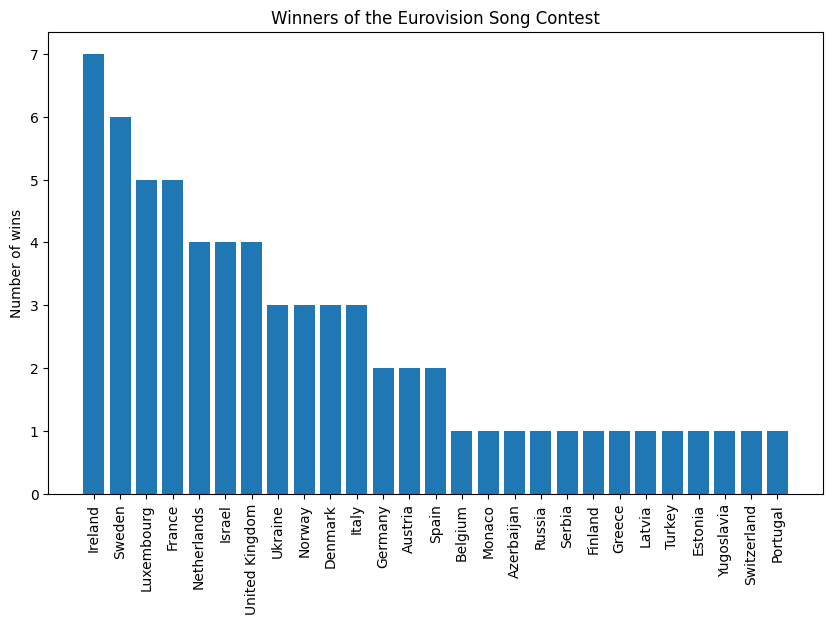

In [151]:

cw = win_table['win_count']
x = win_table['country']

idx_sort = cw.argsort()
cw = cw[idx_sort[::-1]]
x = x[idx_sort[::-1]]

plt.figure(figsize=(10, 6))
plt.bar(x, cw)
plt.xticks(rotation=90)
plt.ylabel('Number of wins')
plt.title('Winners of the Eurovision Song Contest')
plt.show()

In [152]:
# # Delete the countries with less than 10 participations
# participation_counts = participation_counts[participation_counts['participation_count'] >= 10]

# # Update the dataframe
# df_final_round = df_final_round[df_final_round['from_country'].isin(participation_counts['country'])]
# df_final_round = df_final_round[df_final_round['to_country'].isin(participation_counts['country'])]
# df_final_round

In [153]:
# Up to year 2015 put the total point given by a country to another country also in the jury points
df_final_round.loc[df_final_round['year'] <= 2015, 'jury_points'] = df_final_round.loc[df_final_round['year'] <= 2015]['total_points']
df_final_round

,year,round,from_country_id,to_country_id,from_country,to_country,total_points,tele_points,jury_points
0,1957,final,at,nl,Austria,Netherlands,6,NaN,6.0
1,1957,final,at,fr,Austria,France,0,NaN,0.0
2,1957,final,at,dk,Austria,Denmark,0,NaN,0.0
3,1957,final,at,lu,Austria,Luxembourg,3,NaN,3.0
4,1957,final,at,de,Austria,Germany,0,NaN,0.0
...,...,...,...,...,...,...,...,...,...
51349,2023,final,wld,al,World,Albania,6,6.0,NaN
51350,2023,final,wld,pt,World,Portugal,0,0.0,NaN
51351,2023,final,wld,rs,World,Serbia,0,0.0,NaN
51352,2023,final,wld,gb,World,United Kingdom,0,0.0,NaN


### Country analyzer

#### One country analyzer

Number of points given by Spain before 1997 and after 1997 + Boxplot of normalized points

In [154]:
# Function to obtain the number of points given for a given country during a time period

def family_points(df_final_round, country_id, initial_year, crop=20):
    
    # Get the number of points given by country_id to each country
    friends = df_final_round.query(f'year >= {initial_year} and from_country=="{country_id}"')
    
    fig, axs = plt.subplots(ncols=2, nrows=2, figsize=(12,8))
    gs = axs[1,0].get_gridspec()
    for ax in axs[1,:]:
        ax.remove()
    axbig = fig.add_subplot(gs[1,:])
    
    def normalize(df):
        return df / df.sum()
    
    fig.suptitle(f'Normalized points given by {country_id} to each country since {initial_year}', fontsize=16)
    # fig.tight_layout()


    # Plot the  normalized number of jury points given by country_id to each country
    friends1 = friends.groupby('to_country')['jury_points'].sum().sort_values(ascending=False)
    indices = friends1.index
    indices = indices[:crop]
    friends1 = normalize(friends1)
    friends1 = friends1.reset_index()
    friends1.columns = ['country', 'points']
    friends1 = friends1.head(crop)
    x = friends1['country']
    y = friends1['points']
    axs[0,0].bar(x, y, label='Jury')
    # axs[0,0].set_title(f'Normalized points given by {country_id} to each country')
    axs[0,0].set_xticklabels(x, rotation=90, fontsize=8)
    axs[0,0].set_ylabel('Normalized points')
    axs[0,0].legend(fancybox=True, framealpha=1, shadow=True, borderpad=1)
    
    
    # Plot the number of televote points given by country_id to each country
    friends2 = friends.groupby('to_country')['tele_points'].sum().sort_values(ascending=False)
    friends2 = friends2 / friends2.sum()
    friends2 = friends2.reset_index()
    friends2.columns = ['country', 'points']
    friends2 = friends2.head(crop)
    x = friends2['country']
    y = friends2['points']
    axs[0,1].bar(x, y, label='Televote', color='orange')
    # axs[0,1].set_title(f'Normalized Points given by {country_id} to each country')
    axs[0,1].set_xticklabels(x, rotation=90, fontsize=8)
    axs[0,1].legend(fancybox=True, framealpha=1, shadow=True, borderpad=1)
    
    
    # Boxplot of the total points given by country_id to each country though the years
    friends_sorted = friends.groupby('year').apply(lambda x: normalize(x.groupby('to_country')['jury_points'].sum())).reset_index()
    # t = friends_sorted.groupby('to_country').sum().sort_values('jury_points', ascending=False).index
    # t = t[:crop]
    
    sns.boxplot(data=friends_sorted[friends_sorted['to_country'].isin(indices)], x='to_country', y='jury_points', order=indices, ax=axbig, color='skyblue')
    axbig.set_xticklabels(axbig.get_xticklabels(), rotation=90, fontsize=8)
    axbig.set_ylabel('Normalized points')
    axbig.set_title(f'Jury Point distribution though the years')
    axbig.set_xlabel('')
    
    
    plt.subplots_adjust(hspace=0.6)  # Adjust the spacing (increase for more space)

    plt.show()
    
    
    return 


C:\Users\mate1\AppData\Local\Temp\ipykernel_15656\384718967.py:33: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[0,0].set_xticklabels(x, rotation=90, fontsize=8)
C:\Users\mate1\AppData\Local\Temp\ipykernel_15656\384718967.py:48: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[0,1].set_xticklabels(x, rotation=90, fontsize=8)
C:\Users\mate1\AppData\Local\Temp\ipykernel_15656\384718967.py:58: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axbig.set_xticklabels(axbig.get_xticklabels(), rotation=90, fontsize=8)


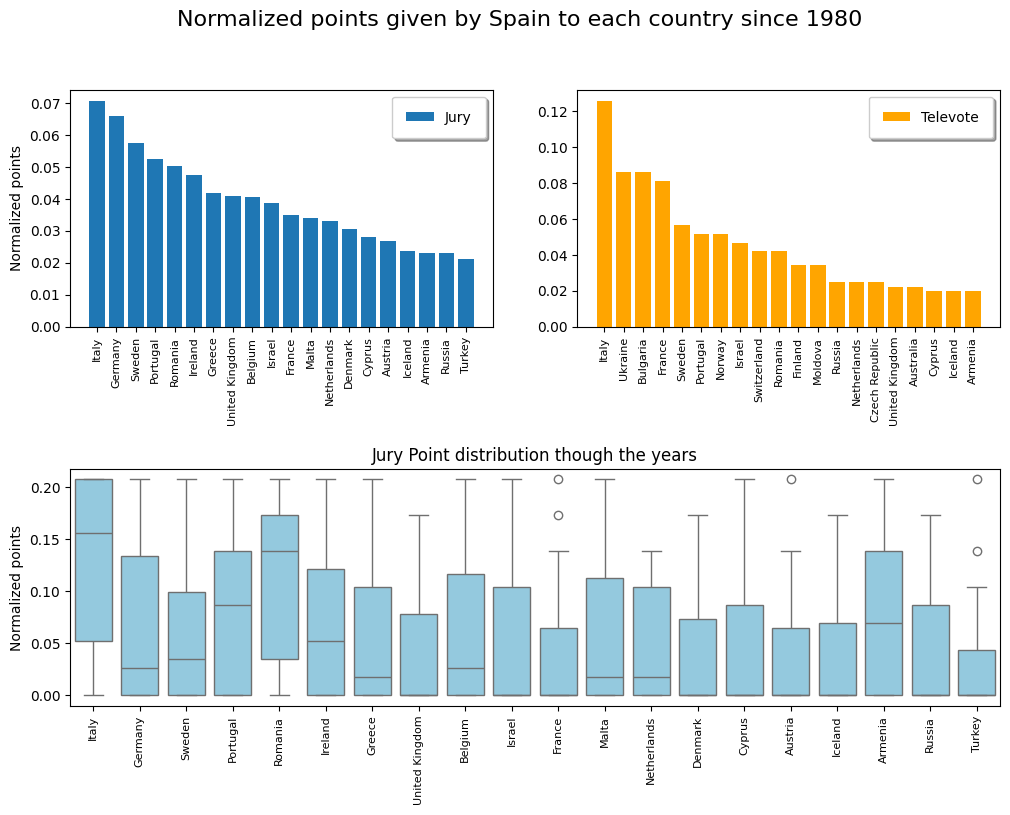

In [155]:
family_points(df_final_round, country_id='Spain', initial_year=1980)

## Analysis

In [156]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import linkage, dendrogram
from scipy.spatial.distance import squareform



### Tree diagram of cohesion cluster analysis

In [166]:
# Cluster analysis by applying Ward algorithm and Squared Euclidean distance
from scipy.cluster.hierarchy import dendrogram, linkage

def cluster_analysis(df, initial_year, final_year, N_top=70):
    
    # Filter the data
    df_filtered = df[(df['year'] >= initial_year) & (df['year'] <= final_year)]
    participations = participation_counts_f(df, initial_year, final_year)
    
    # Delete the countries with less than 10 participations
    participations = participations[participations['participation_count'] >= 5]

    # Update the dataframe
    df_filtered = df_filtered[df_filtered['from_country'].isin(participations['country'])]
    
    # Find the top N countries during the time period
    top_countries = df_filtered['from_country'].value_counts().index[:N_top]
    
    # Normalize the jury points
    # Obtain the total points given by each country to each other
    total_points = df_filtered.groupby(['from_country', 'to_country'])['jury_points'].sum().unstack().fillna(0)
    
    # # Normalize the points
    # total_points = total_points.apply(lambda x: x / x.sum(), axis=1)
    
    # Create an interaction matrix for the top countries
    interaction_matrix = pd.DataFrame(0.0, index=top_countries, columns=top_countries)
        
    # Fill the matrix with the average normalized points given by each country to each other
    for country in top_countries:
        interaction_matrix.loc[country] = total_points.loc[country]
    
    interaction_matrix = interaction_matrix.fillna(0)    
    
    # Apply the Ward algorithm and Squared Euclidean distance
    Z = linkage(interaction_matrix, method='ward', metric='euclidean')
    
    # Plot the dendrogram and correlation matrix
    plt.figure(figsize=(12, 6))
    
    # Plot the dendrogram
    dendrogram(Z, labels=interaction_matrix.index, orientation='right')
    plt.title(f'Dendrogram of the top countries from {initial_year} to {final_year}')
    plt.show()

    return

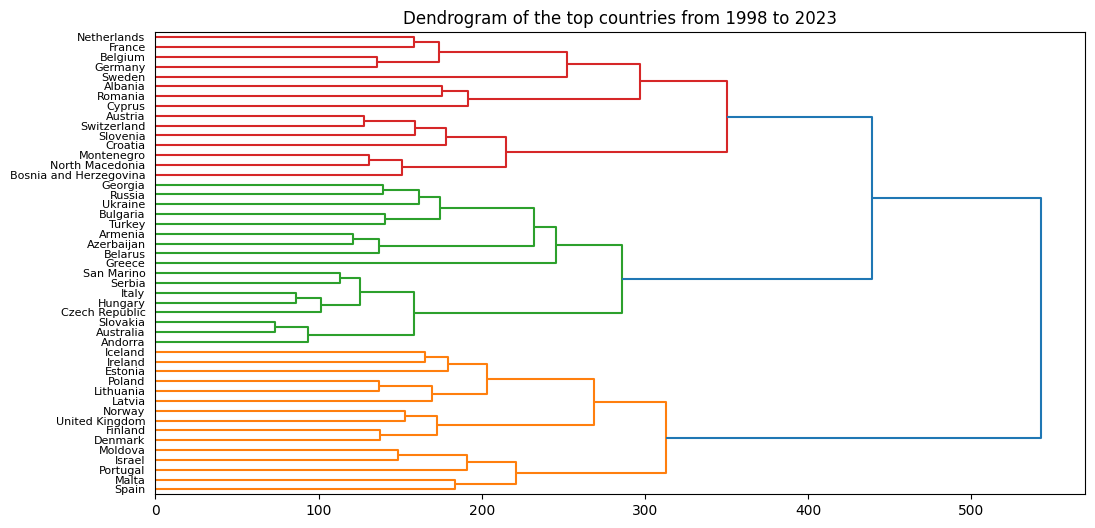

In [167]:
cluster_analysis(df_final_round, initial_year=1998, final_year=2023, N_top=70)

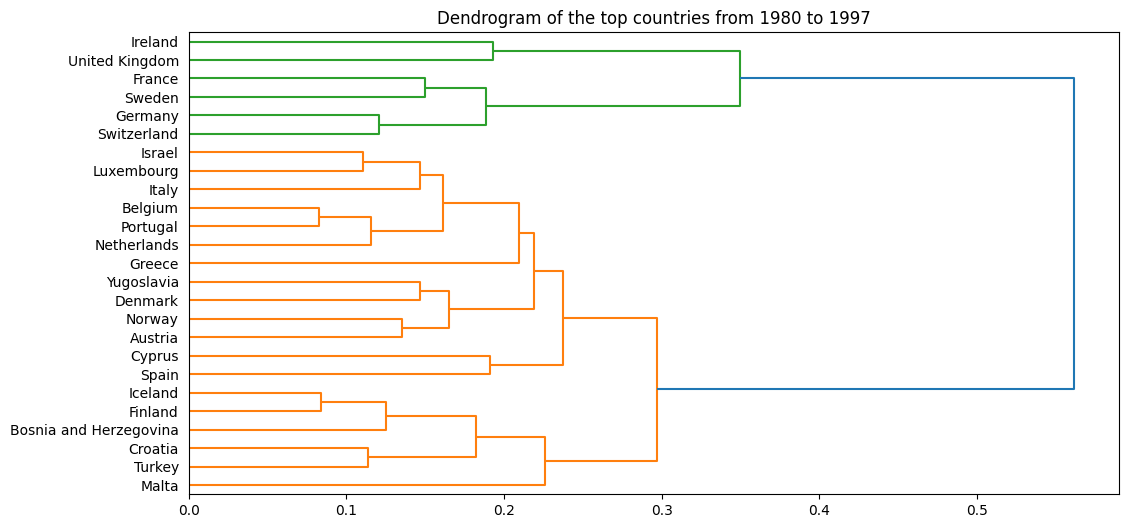

In [159]:
cluster_analysis(df_final_round, initial_year=1980, final_year=1997, N_top=50)

In this cluster analysis we compare the voting portfolios between countries for different range of years, by applying the Wards method and euclidean distance which produce the least biased results. The Warts method seeks to minimize the total within-cluster variance as clusters are merged. At each step of the algorithm:

- It computes the increase in total within-cluster variance that would result from merging any two clusters.
- It selects the pair of clusters whose merging causes the smallest increase in this variance.

This leads to a hierarchy of clusters, visualized as a dendrogram.

### Study of Bias

We define quality as the average aggregate number of points from all the other country juries to song $C_j$ in year $t$:

$$\text{Quality}\quad C_{jt} = \frac{1}{p-2}\sum_{p\neq i,j} C_{ijt}$$

Thenb, the bias is defined as:

$$\text{Bias} \, C_{ijt} = \text{Vote} \, C_{ijt} - \text{Quality} \, C_{jt}$$

In [174]:
def bias_dyads(df, initial_year, final_year, N_top=15):
    
    # Filter the data
    df_filtered = df[(df['year'] >= initial_year) & (df['year'] <= final_year)]
    participations = participation_counts_f(df, initial_year, final_year)
    
    # Delete the countries with less than 10 participations
    participations = participations[participations['participation_count'] >= 5]
    
    # Update the dataframe
    df_filtered = df_filtered[df_filtered['from_country'].isin(participations['country'])]
    
    # Obtain the total points given by each country to each other
    given_points_yearly = df_filtered.groupby(['year', 'to_country'])['jury_points'].sum().unstack().fillna(0)
    
    # Obtain the number of participants of each year
    participants = df_filtered.groupby('year')['to_country'].nunique()
    
    # Create a dataframe to store the quality of country song per year
    quality = pd.DataFrame(0.0, index=participants.index, columns=given_points_yearly.columns)
    
    # Compute the quality of the song of each country per year
    for year in participants.index:
        for country in given_points_yearly.columns:
            quality.loc[year, country] = given_points_yearly.loc[year, country] / (participants.loc[year] - 2)
    
    # Compute the average bias of each country to each other
    bias = pd.DataFrame(0.0, index=given_points_yearly.columns, columns=given_points_yearly.columns)
    counts = pd.DataFrame(0, index=given_points_yearly.columns, columns=given_points_yearly.columns)
    p_values = pd.DataFrame(0.0, index=given_points_yearly.columns, columns=given_points_yearly.columns)
    
    for country in given_points_yearly.columns:
        for country2 in given_points_yearly.columns:
            if country != country2:
                total_bias = 0
                count = 0
                all_biases = []
                for year in participants.index:
                    # Check if both countries participated in the same year
                    countries_in_year = df_filtered[df_filtered['year'] == year]['to_country'].values
                    if country in countries_in_year and country2 in countries_in_year:
                        points_between = df_filtered[
                            (df_filtered['year'] == year) & 
                            (df_filtered['from_country'] == country) & 
                            (df_filtered['to_country'] == country2)
                        ]['jury_points'].sum()  # Ensure it sums to a scalar value
                        
                        # Compute bias for this year
                        b = points_between - quality.loc[year, country2]
                        all_biases.append(b)
                        total_bias += b
                        count += 1
                        
                # Perform t-test for p-values
                t_stat, p_value = stats.ttest_1samp(all_biases, 0)  # Test against 0 (null hypothesis)
                
                # Store the results
                p_values.loc[country, country2] = p_value
                counts.loc[country, country2] = count
                if count > 0:
                    bias.loc[country, country2] = total_bias / count
    
    # Ensure index names are set correctly
    bias.index = bias.index.rename('from_country')
    counts.index = counts.index.rename('from_country')
    p_values.index = p_values.index.rename('from_country')

    # Reset index and reshape the DataFrame using .melt()
    bias_reset = bias.reset_index().melt(id_vars=['from_country'], value_vars=bias.columns, var_name='to_country', value_name='bias')
    counts_reset = counts.reset_index().melt(id_vars=['from_country'], value_vars=counts.columns, var_name='to_country', value_name='count')
    p_values_reset = p_values.reset_index().melt(id_vars=['from_country'], value_vars=p_values.columns, var_name='to_country', value_name='p_value')


    # Merge the bias, counts and p-values into a single DataFrame
    result = pd.merge(bias_reset, counts_reset, on=['from_country', 'to_country'])
    result = pd.merge(result, p_values_reset, on=['from_country', 'to_country'])

    # Sort based on biased dyads
    result = result.sort_values('bias', ascending=False)
    result = result[result['count'] > 1]
    # result = result.head(N_top)
    
    return result


In [26]:
bias1 = bias_dyads(df_final_round, initial_year=1998, final_year=2023)
bias1

c:\Users\mate1\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\stats\_stats_py.py:1103: RuntimeWarning: divide by zero encountered in divide
  var *= np.divide(n, n-ddof)  # to avoid error on division by zero
c:\Users\mate1\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\stats\_stats_py.py:1103: RuntimeWarning: invalid value encountered in scalar multiply
  var *= np.divide(n, n-ddof)  # to avoid error on division by zero
c:\Users\mate1\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\mate1\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
c:\Users\mate1\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\stats\_axis_nan_policy.py:523: RuntimeWarning: Precision loss occurred in

,from_country,to_country,bias,count,p_value
488,Greece,Cyprus,9.385755,11,1.235548e-08
1317,Armenia,Montenegro,8.349167,2,1.575271e-01
856,Cyprus,Greece,7.915435,11,2.077075e-05
30,North Macedonia,Albania,7.406250,4,4.009214e-03
1303,Romania,Moldova,6.962879,10,1.133063e-04
1356,Slovenia,Montenegro,6.849167,2,1.275416e-01
338,Croatia,Bosnia and Herzegovina,6.344268,9,2.853396e-06
777,Lithuania,Georgia,6.270327,5,6.182134e-04
430,Bosnia and Herzegovina,Croatia,6.210440,9,6.367671e-04
1625,Moldova,Romania,6.194631,10,6.659913e-04


In [27]:
bias2 = bias_dyads(df_final_round, initial_year=1975, final_year=1997)
bias2

c:\Users\mate1\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\stats\_stats_py.py:1103: RuntimeWarning: divide by zero encountered in divide
  var *= np.divide(n, n-ddof)  # to avoid error on division by zero
c:\Users\mate1\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\stats\_stats_py.py:1103: RuntimeWarning: invalid value encountered in scalar multiply
  var *= np.divide(n, n-ddof)  # to avoid error on division by zero
c:\Users\mate1\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\mate1\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


,from_country,to_country,bias,count,p_value
963,Malta,Slovakia,9.340580,2,1.347572e-01
354,Cyprus,Greece,8.288465,13,9.816049e-09
150,Greece,Cyprus,6.800702,13,4.076369e-06
102,Turkey,Bosnia and Herzegovina,6.395963,4,3.639506e-02
633,Croatia,Malta,5.716356,5,2.141827e-02
123,Malta,Croatia,5.284058,5,5.474866e-02
931,Netherlands,Russia,5.239130,2,2.481365e-01
243,United Kingdom,Estonia,4.431332,3,1.897103e-01
613,Malta,Luxembourg,4.424463,4,2.333193e-01
549,Portugal,Italy,4.391653,17,5.285203e-05


Now we are ineterested in studying how different are the voting portfolios between different countries. First we compute the number of points given for all the countries to each country and normalize. Then, we compute the correlation matrix between countries based on their portfolios. After that, we compute the distance between correlations and plot a dendogram.

In [124]:
from scipy.cluster.hierarchy import fcluster
import scipy.cluster.hierarchy as sch

In [130]:
# Convert correlation matrix to distance matrix
def correlation_to_distance(corr):
    return np.sqrt(2 * (1 - corr))

# Correlation function
def correlation(df, initial_year, final_year):
    
    # Filter data in time
    friends = df.query(f'year >= {initial_year} and year <= {final_year}')
    participations = participation_counts_f(df, initial_year, final_year)
    
    # Delete the countries with less than 10 participations
    participations = participations[participations['participation_count'] >= 5]

    # Update the dataframe
    friends = friends[friends['from_country'].isin(participations['country'])]
    # friends = friends[friends['to_country'].isin(participations['country'])]
    
    # Get the number of points given by each country to each country
    friends = friends.groupby(['from_country', 'to_country'])['total_points'].mean().unstack().fillna(0)
    
    # # Normalize the data
    # friends = friends.apply(lambda x: x / x.sum(), axis=1)
    
    # Get the correlation matrix
    corr = friends.T.corr()
    
    plt.figure(figsize=(12, 10))
    sns.heatmap(corr, cmap='coolwarm', annot=False) 
    plt.title('Correlation matrix of the points given by each country to each country')
    plt.show()
    
    return corr

# Hierarchical clustering function
def hierarchical_clustering(corr):
    
    # Convert correlation matrix to distance matrix
    dist = correlation_to_distance(corr)
    
    plt.figure(figsize=(12, 6))
    sns.heatmap(dist, cmap='coolwarm', annot=False)
    plt.title('Distance matrix of the points given by each country to each country')
    
    # Flatten the distance matrix
    dist = squareform(dist)
    
    # Perform hierarchical clustering
    Z = linkage(dist, method='ward', metric='euclidean')

    return Z, corr

def plotting_dendrogram(Z, corr, threshold=0.5):
    
    # Plot the dendrogram
    plt.figure(figsize=(12, 6))
    sch.dendrogram(Z, labels=corr.index, orientation='right', color_threshold=threshold)
    plt.axvline(x=threshold, color='black', linestyle='--')
    plt.title('Dendrogram of the points given by each country to each country')
    plt.show()
    
    return

def get_clusters(Z, corr, cutoff_distance):
    
    # Get the cluster labels
    cluster_labels = fcluster(Z, t=cutoff_distance, criterion='distance')
    # Create a DataFrame with the cluster labels
    clusters = pd.DataFrame(cluster_labels, index=corr.index, columns=['cluster'])
    
    return clusters

def bias_among_cluster(cluster, df, initial_year, final_year):
    
    # Filter the data
    df_filtered = df[(df['year'] >= initial_year) & (df['year'] <= final_year)]
    participations = participation_counts_f(df, initial_year, final_year)
    
    # Delete the countries with less than 10 participations
    participations = participations[participations['participation_count'] >= 1]
    
    # Update the dataframe
    df_filtered = df_filtered[df_filtered['from_country'].isin(participations['country'])]
    
    # Obtain the total points given by each country to each other
    given_points_yearly = df_filtered.groupby(['year', 'to_country'])['jury_points'].sum().unstack().fillna(0)
    
    # Obtain the number of participants of each year
    participants = df_filtered.groupby('year')['to_country'].nunique()
    
    # Create a dataframe to store the quality of country song per year
    quality = pd.DataFrame(0.0, index=participants.index, columns=given_points_yearly.columns)
    
    # Compute the quality of the song of each country per year
    for year in participants.index:
        for country in given_points_yearly.columns:
            quality.loc[year, country] = given_points_yearly.loc[year, country] / (participants.loc[year] - 2)

    # Get the different clusters
    cluster_types = cluster['cluster'].unique()
    
    # Create a DataFrame to store the results
    results = pd.DataFrame(np.nan, index=cluster_types, columns=participants.index)
    p_values = pd.DataFrame(np.nan, index=cluster_types, columns=participants.index)
    
    for c in cluster_types:
        
        # Get the countries in the cluster
        countries = cluster[cluster['cluster'] == c].index
        
        for year in participants.index:
            total_bias = 0
            count = 0
            all_biases = []
            for country in countries:
                for country2 in countries:
                    if country != country2:
                        # Check if both countries participated in the same year
                        countries_in_year = df_filtered[df_filtered['year'] == year]['to_country'].values
                        if country in countries_in_year and country2 in countries_in_year:
                            points_between = df_filtered[
                                    (df_filtered['year'] == year) & 
                                    (df_filtered['from_country'] == country) & 
                                    (df_filtered['to_country'] == country2)
                                ]['jury_points'].sum()
                                
                            # Compute bias for this year
                            b = points_between - quality.loc[year, country2]
                            all_biases.append(b)
                            total_bias += b
                            count += 1
                            
            # Perform t-test for p-values
            t_stat, p_value = stats.ttest_1samp(all_biases, 0)
                    
            # Store the results
            p_values.loc[c, year] = p_value
            results.loc[c, year] = total_bias / count if count > 0 else np.nan
        
    return results, p_values

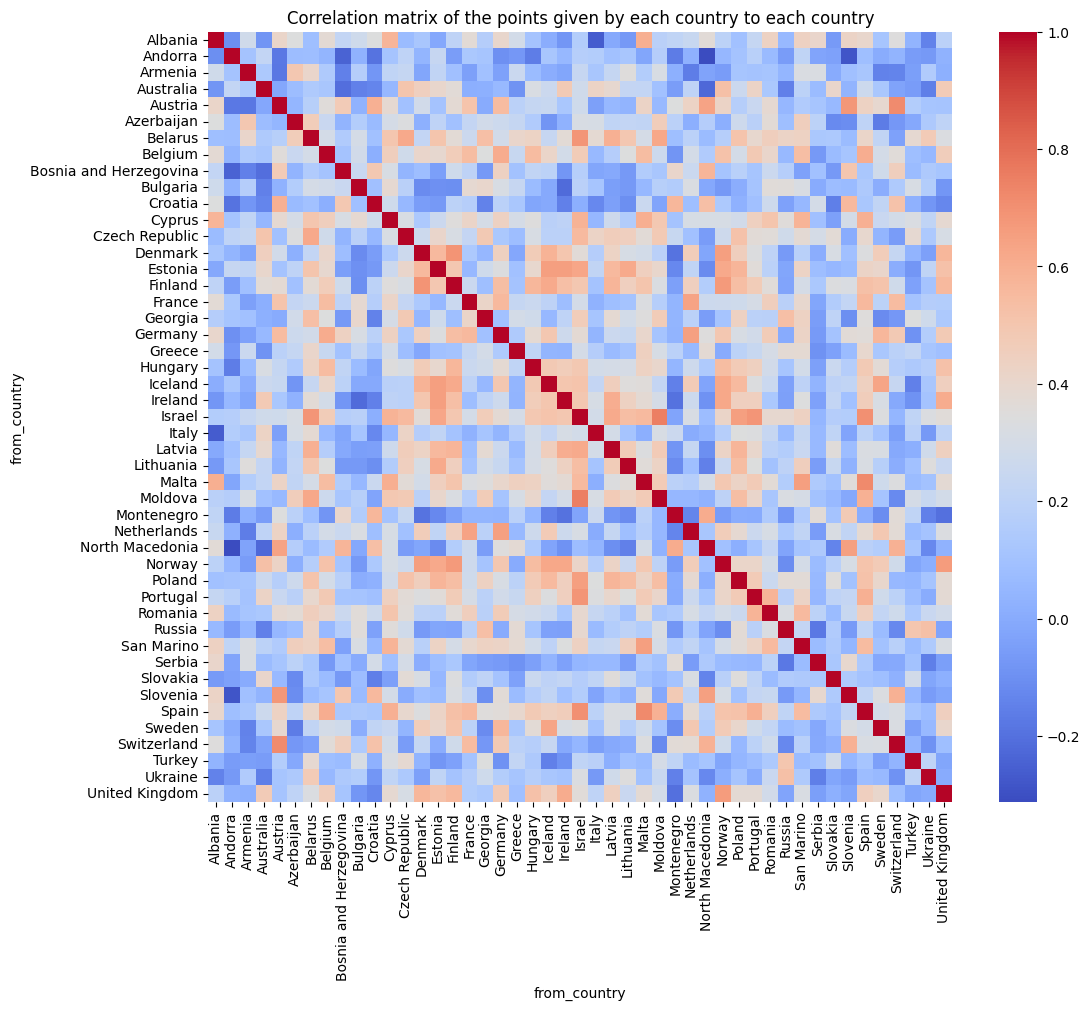

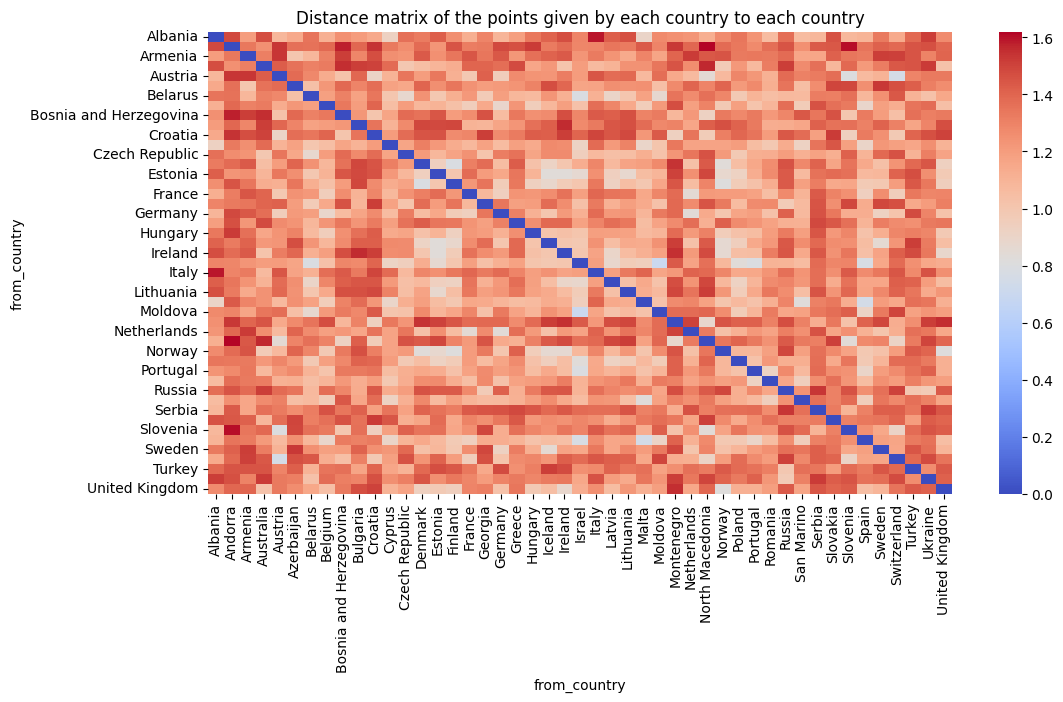

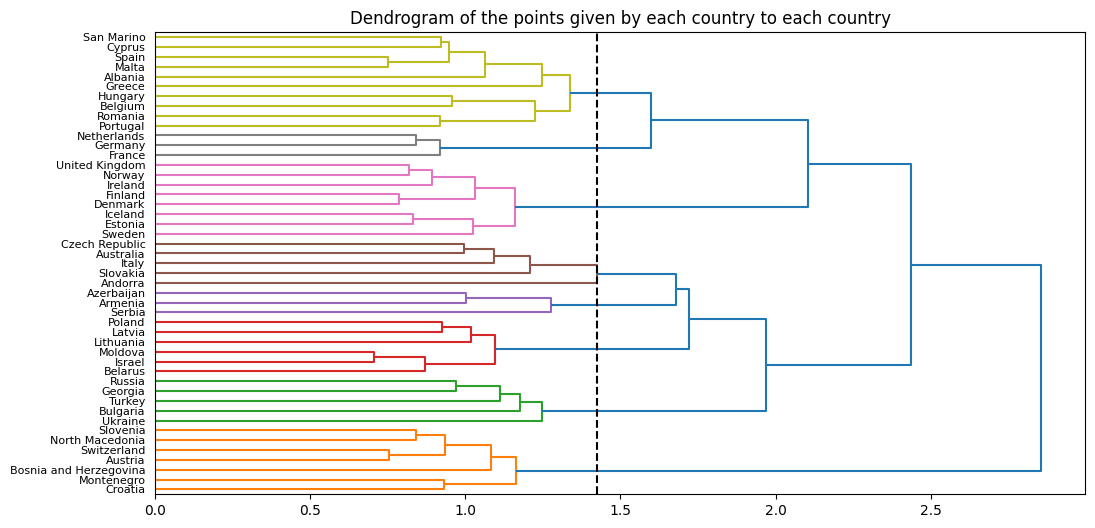

array([[57.        , 84.        ,  1.59762334, 13.        ],
       [83.        , 85.        ,  1.67975562,  8.        ],
       [74.        , 87.        ,  1.72146234, 14.        ],
       [81.        , 88.        ,  1.96784248, 19.        ],
       [76.        , 86.        ,  2.1053297 , 21.        ],
       [89.        , 90.        ,  2.43692935, 40.        ],
       [77.        , 91.        ,  2.8562125 , 47.        ]])

In [134]:
threshold = 1.425
Z, corr = hierarchical_clustering(correlation(df_final_round, initial_year=1998, final_year=2023))
plotting_dendrogram(Z, corr, threshold)
Z[Z[:, 2] > threshold]

In [171]:
cluster = get_clusters(Z, corr, cutoff_distance=threshold)

cluster

# results, p_values = bias_among_cluster(cluster, df_final_round, initial_year=1998, final_year=2023)
# results

,cluster
from_country,
Albania,8
Andorra,5
Armenia,4
Australia,5
Austria,1
Azerbaijan,4
Belarus,3
Belgium,8
Bosnia and Herzegovina,1


In [ ]:
def edges_(df, initial_year, final_year, N_top=15):
    
    # Filter the data
    df_filtered = df[(df['year'] >= initial_year) & (df['year'] <= final_year)]
    participations = participation_counts_f(df, initial_year, final_year)
    
    # Delete the countries with less than 10 participations
    participations = participations[participations['participation_count'] >= 5]
    
    # Update the dataframe
    df_filtered = df_filtered[df_filtered['from_country'].isin(participations['country'])]
    
    # Obtain the total points given by each country to each other
    given_points_yearly = df_filtered.groupby(['year', 'to_country'])['jury_points'].sum().unstack().fillna(0)
    
    # Obtain the number of participants of each year
    participants = df_filtered.groupby('year')['to_country'].nunique()
    
    # Create a dataframe to store the quality of country song per year
    quality = pd.DataFrame(0.0, index=participants.index, columns=given_points_yearly.columns)
    
    # Compute the quality of the song of each country per year
    for year in participants.index:
        for country in given_points_yearly.columns:
            quality.loc[year, country] = given_points_yearly.loc[year, country] / (participants.loc[year] - 2)
    
    # Compute the average bias of each country to each other
    bias = pd.DataFrame(0.0, index=given_points_yearly.columns, columns=given_points_yearly.columns)
    counts = pd.DataFrame(0, index=given_points_yearly.columns, columns=given_points_yearly.columns)
    p_values = pd.DataFrame(0.0, index=given_points_yearly.columns, columns=given_points_yearly.columns)
    
    for country in given_points_yearly.columns:
        for country2 in given_points_yearly.columns:
            if country != country2:
                total_bias = 0
                count = 0
                all_biases = []
                for year in participants.index:
                    # Check if both countries participated in the same year
                    countries_in_year = df_filtered[df_filtered['year'] == year]['to_country'].values
                    if country in countries_in_year and country2 in countries_in_year:
                        points_between = df_filtered[
                            (df_filtered['year'] == year) & 
                            (df_filtered['from_country'] == country) & 
                            (df_filtered['to_country'] == country2)
                        ]['jury_points'].sum()  # Ensure it sums to a scalar value
                        
                        # Compute bias for this year
                        b = points_between - quality.loc[year, country2]
                        all_biases.append(b)
                        total_bias += b
                        count += 1
                        
                # Perform t-test for p-values
                t_stat, p_value = stats.ttest_1samp(all_biases, 0)  # Test against 0 (null hypothesis)
                
                # Store the results
                p_values.loc[country, country2] = p_value
                counts.loc[country, country2] = count
                if count > 0:
                    bias.loc[country, country2] = total_bias / count
    
    # Ensure index names are set correctly
    bias.index = bias.index.rename('from_country')
    counts.index = counts.index.rename('from_country')
    p_values.index = p_values.index.rename('from_country')

    # Reset index and reshape the DataFrame using .melt()
    bias_reset = bias.reset_index().melt(id_vars=['from_country'], value_vars=bias.columns, var_name='to_country', value_name='bias')
    counts_reset = counts.reset_index().melt(id_vars=['from_country'], value_vars=counts.columns, var_name='to_country', value_name='count')
    p_values_reset = p_values.reset_index().melt(id_vars=['from_country'], value_vars=p_values.columns, var_name='to_country', value_name='p_value')


    # Merge the bias, counts and p-values into a single DataFrame
    result = pd.merge(bias_reset, counts_reset, on=['from_country', 'to_country'])
    result = pd.merge(result, p_values_reset, on=['from_country', 'to_country'])

    # Sort based on biased dyads
    result = result.sort_values('bias', ascending=False)
    result = result[result['count'] > 1]
    # result = result.head(N_top)
    
    return result

In [202]:
# Create a network graph with the clusters and linked with the dyads with significant bias

def network_graph(df, bias_dyads, initial_year, final_year, clusters):
    
    # Get the bias dyads
    bias_d = bias_dyads(df, initial_year, final_year)
    
    # Create a network graph
    G = nx.Graph()
    
    # Add the nodes
    for country in clusters.index:
        G.add_node(country, cluster=clusters.loc[country, 'cluster'])
        
    # Add the edges
    for i, row in bias_d.iterrows():
        if row['bias'] > -2 and row['p_value'] < 0.05 and row['count'] > 1:
            G.add_edge(row['from_country'], row['to_country'], weight=row['bias'])
            
    node_deg = np.array([k for x,k in dict(G.degree()).items()])

    # Plot the network graph
    nx.draw(G, 
            pos = nx.spring_layout(G),
            node_color = [clusters.loc[country, 'cluster'] for country in G.nodes],
            node_cmap = plt.cm.tab20,
            with_labels=True,
            node_size = 100*np.sqrt(node_deg),
            edge_color = [G[u][v]['weight'] for u,v in G.edges],
            edge_cmap = plt.cm.afmhot,
            font_weight='bold',
            font_size=7)
            
    plt.title('Network graph of the clusters and bias dyads')
    plt.show()
    
    return

c:\Users\mate1\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\stats\_stats_py.py:1103: RuntimeWarning: divide by zero encountered in divide
  var *= np.divide(n, n-ddof)  # to avoid error on division by zero
c:\Users\mate1\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\stats\_stats_py.py:1103: RuntimeWarning: invalid value encountered in scalar multiply
  var *= np.divide(n, n-ddof)  # to avoid error on division by zero
c:\Users\mate1\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\mate1\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
c:\Users\mate1\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\stats\_axis_nan_policy.py:523: RuntimeWarning: Precision loss occurred in

ValueError: Received invalid argument(s): node_cmap

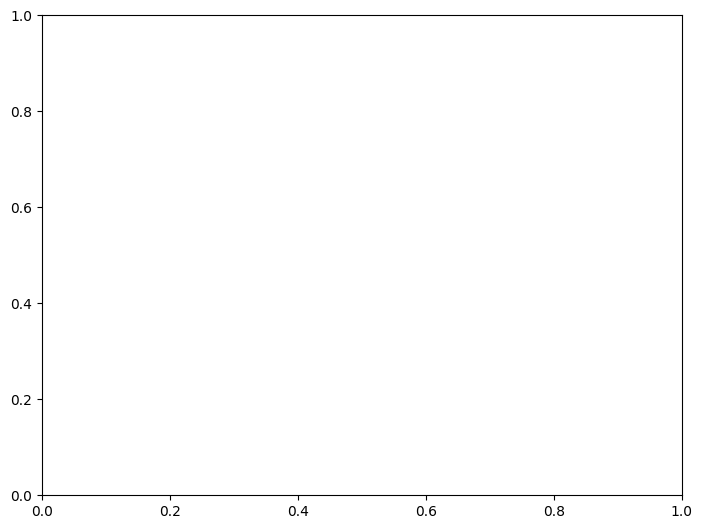

In [203]:
network_graph(df_final_round, bias_dyads, initial_year=1998, final_year=2023, clusters = cluster)

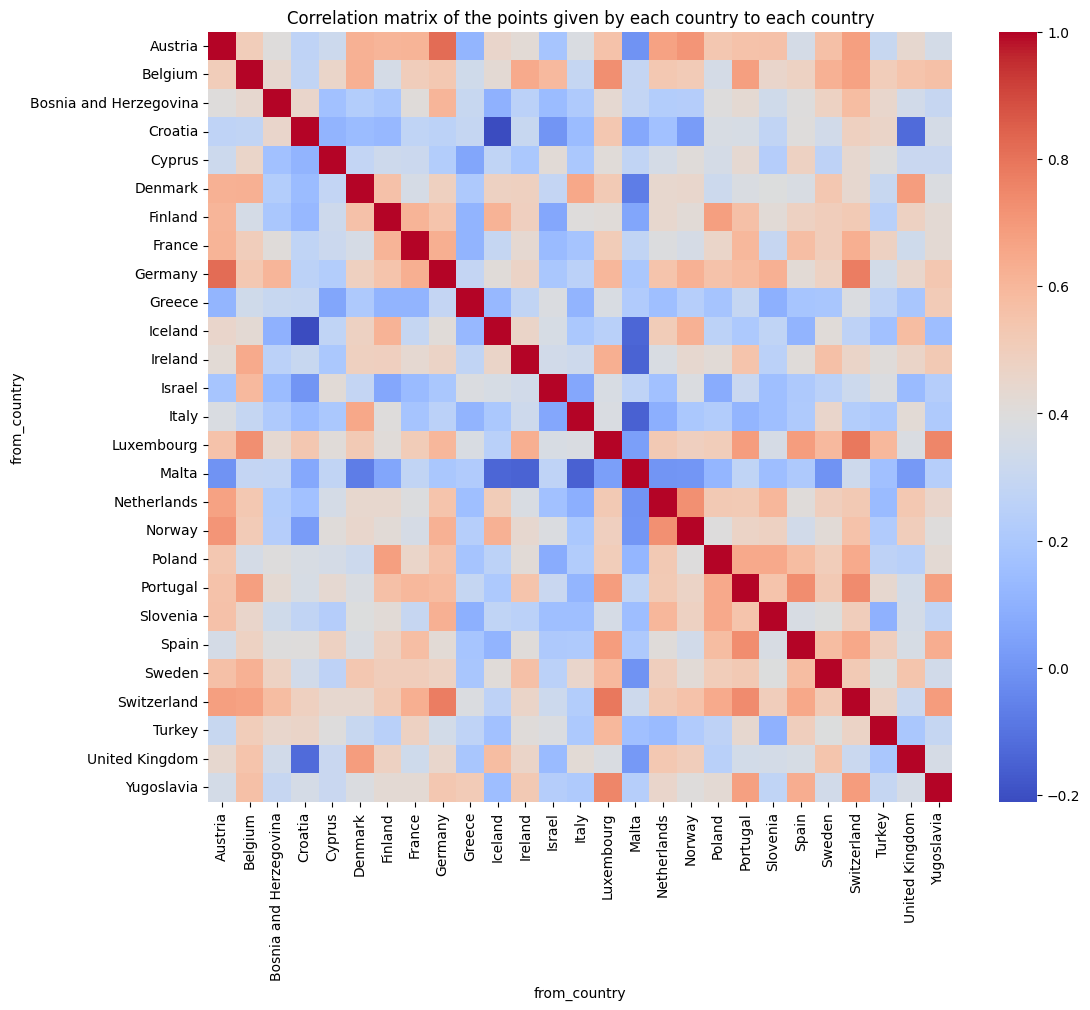

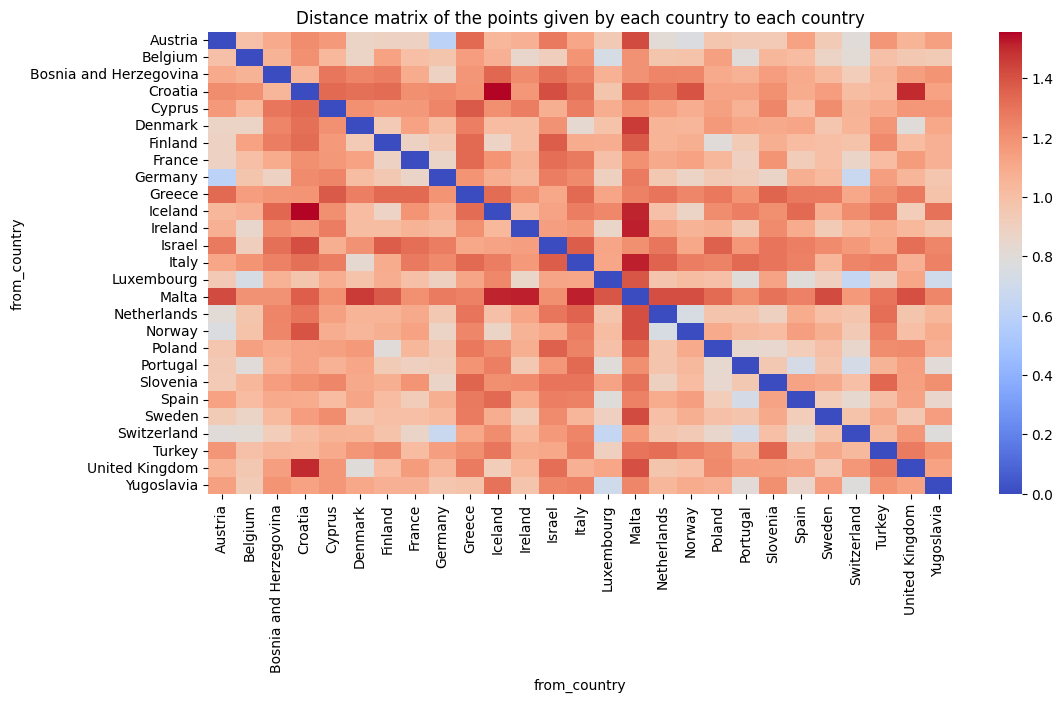

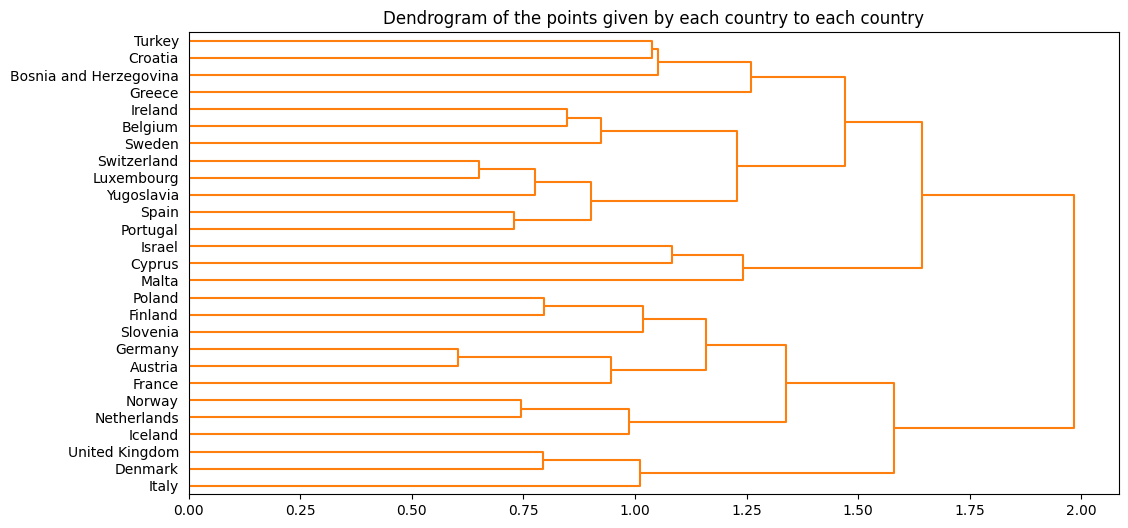

array([[ 0.        ,  8.        ,  0.60312818,  2.        ],
       [19.        , 21.        ,  0.72911071,  2.        ],
       [26.        , 28.        ,  0.77521323,  3.        ],
       [ 6.        , 18.        ,  0.79625835,  2.        ],
       [29.        , 31.        ,  0.90232334,  5.        ],
       [ 7.        , 27.        ,  0.94567738,  3.        ],
       [13.        , 32.        ,  1.01074008,  3.        ],
       [ 3.        , 24.        ,  1.03692468,  2.        ],
       [ 4.        , 12.        ,  1.08168366,  2.        ],
       [35.        , 36.        ,  1.22843816,  8.        ],
       [ 9.        , 42.        ,  1.26047494,  4.        ],
       [45.        , 47.        ,  1.47117967, 12.        ],
       [46.        , 49.        ,  1.6432916 , 15.        ]])

In [132]:
threshold = 2.115
Z, corr = hierarchical_clustering(correlation(df_final_round, initial_year=1980, final_year=1998))
plotting_dendrogram(Z, corr, threshold)
Z[::2]

In [88]:
cluster = get_clusters(Z, corr, cutoff_distance=threshold)

results, p_values = bias_among_cluster(cluster, df_final_round, initial_year=1993, final_year=2007)
results

c:\Users\mate1\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\mate1\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


year,1993,1994,1995,1996,1997,1998,1999,2000,2001,2002,2003,2004,2005,2006,2007
4,9.260870,10.086957,8.761905,10.952381,10.304348,11.478261,8.619048,9.318182,8.047619,10.772727,11.375000,9.181818,9.909091,7.863636,8.181818
2,5.173913,7.913043,7.904762,7.571429,7.217391,8.565217,8.619048,9.954545,5.238095,6.727273,9.791667,6.681818,6.318182,6.863636,6.136364
3,10.608696,8.826087,8.380952,8.761905,6.956522,8.260870,9.619048,8.681818,8.619048,10.000000,6.875000,7.727273,6.772727,10.636364,6.681818
1,NaN,6.956522,4.142857,5.523810,5.565217,2.521739,6.190476,5.818182,8.333333,7.500000,8.750000,6.954545,7.409091,6.636364,8.727273


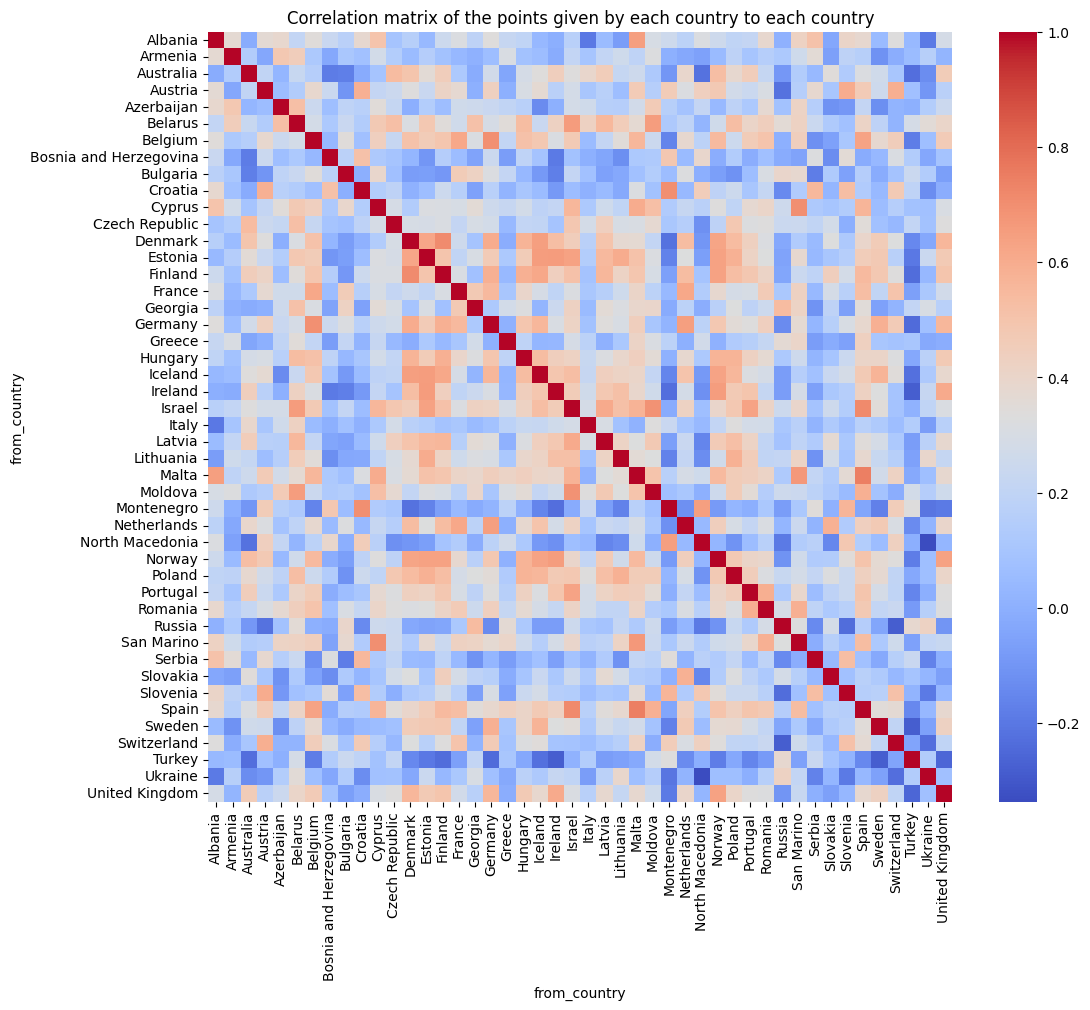

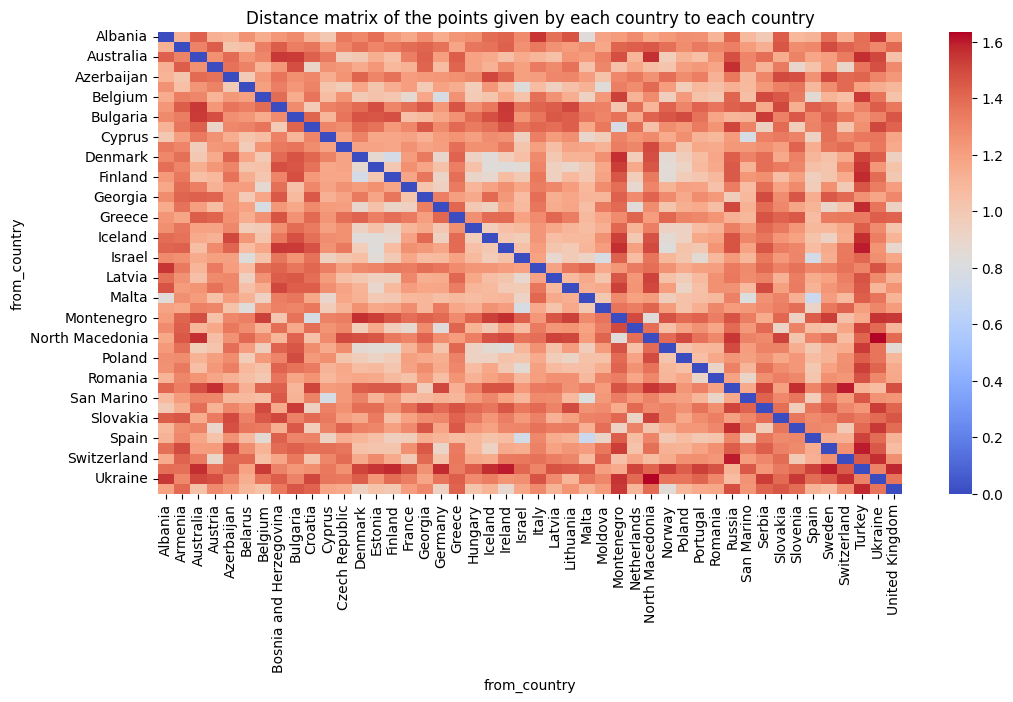

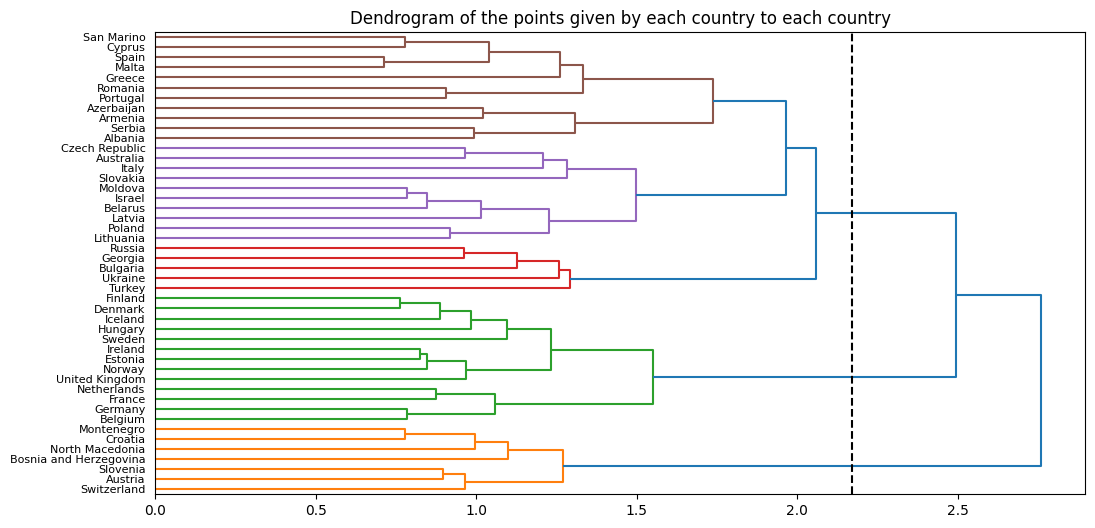

array([[26.        , 40.        ,  0.71262183,  2.        ],
       [10.        , 36.        ,  0.77676085,  2.        ],
       [ 6.        , 17.        ,  0.78436678,  2.        ],
       [13.        , 21.        ,  0.82525079,  2.        ],
       [ 5.        , 51.        ,  0.84758317,  3.        ],
       [20.        , 47.        ,  0.88831846,  3.        ],
       [33.        , 34.        ,  0.90697301,  2.        ],
       [16.        , 35.        ,  0.96036235,  2.        ],
       [42.        , 57.        ,  0.96578154,  3.        ],
       [19.        , 56.        ,  0.98378324,  4.        ],
       [30.        , 49.        ,  0.9963874 ,  3.        ],
       [ 1.        ,  4.        ,  1.02039439,  2.        ],
       [50.        , 55.        ,  1.05735687,  4.        ],
       [ 7.        , 66.        ,  1.09958708,  4.        ],
       [23.        , 61.        ,  1.20877324,  3.        ],
       [63.        , 71.        ,  1.23430706,  9.        ],
       [18.        , 69.

In [89]:
threshold = 2.172
Z, corr = hierarchical_clustering(correlation(df_final_round, initial_year=2008, final_year=2023))
plotting_dendrogram(Z, corr, vline=2.172)
Z[::2]

In [44]:
cluster = get_clusters(Z, corr, cutoff_distance=threshold)

results, p_values = bias_among_cluster(cluster, df_final_round, initial_year=2008, final_year=2023)
results

c:\Users\mate1\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\mate1\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


year,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,2021,2022,2023
12,-5.094203,-4.195652,-5.043478,0.000000,-4.166667,-5.729167,-4.312500,-1.560000,-3.312500,-2.833333,0.000000,2.395833,-0.125000,-3.108696,3.208333
5,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-2.653333,-4.416667,-6.187500,-2.819444,-3.416667,0.000000,-2.884058,-2.388889
7,2.065217,0.000000,0.000000,2.282609,0.000000,0.000000,-0.229167,1.106667,-0.138889,-1.958333,-1.694444,-1.687500,0.000000,0.000000,1.979167
9,0.000000,0.000000,2.521739,0.000000,0.000000,1.520833,0.000000,0.000000,0.000000,-1.833333,0.000000,0.000000,0.000000,0.000000,0.000000
1,-0.869565,-1.637681,-3.380435,-3.355072,-1.305556,-0.750000,-1.572917,0.106667,-1.010417,-1.558333,-0.486111,-0.555556,-0.468750,-0.617391,-2.388889
6,0.000000,0.000000,0.000000,0.000000,6.875000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
8,0.000000,0.000000,-1.043478,0.000000,0.000000,0.000000,0.000000,-1.240000,-2.972222,-3.041667,-4.395833,0.645833,-1.819444,0.000000,0.000000
2,0.836957,-3.547101,0.355072,-1.036232,-0.222222,-0.958333,0.333333,-2.140000,0.000000,-1.291667,-0.500000,0.447917,-1.135417,-1.945652,-0.229167
4,0.036232,0.025362,-1.413043,-0.706522,0.091667,-0.183333,-0.819444,0.600000,-0.930556,-2.291667,0.083333,-1.541667,-0.597222,-0.502174,-0.854167
11,-3.992754,-3.293478,-2.771739,1.507246,-1.791667,-3.666667,1.708333,-2.520000,-7.104167,-1.250000,0.000000,6.333333,-2.388889,-4.108696,0.000000


### Network

### Hypothesis test